# <span style='color:SteelBlue'>P6 - Classifiez automatiquement des biens de consommation (part 1)</span>

<img src="https://user.oc-static.com/upload/2019/02/24/15510259240381_Projet%20textimage%20logo.png" width="600" height="400">

# <span style='background:red; color:black'>a MAJ</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des donnees <br>

**Etape 1 : Description des donnees**
- _1/ etc..._


Conclusion

# <span style='background:blue'>Introduction</span>

L'entreprise **"place de marché"** est une entreprise qui souhaite lancer une
marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs
proposent des articles à des acheteurs en postant une photo et une description.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne
de nouveaux articles) et des acheteurs (faciliter la recherche de produits) 
la plus fluide possible, et dans l'optique d'un passage à l'échelle, 
il devient nécessaire **d'automatiser l'attribution de la catégorie** d'un 
article (actuellement effectuée manuellement par les vendeurs, donc peu 
fiable).
___
**Missions**<br>
1/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une image et une description pour automatiser l’attribution
de catégorie de l’article. 

2/ **Réaliser une classification supervisée** à partir des images par la mise
en place d’une data augmentation afin d’optimiser le modèle. 

3/ **Extraire les 10 premiers produits à base de « champagne »** issus de
l’API fournie dans un fichier “.csv”, contenant pour chaque produit les
données suivantes : foodId, label, category, foodContentsLabel, image.
___
Ce notebook presente la 2ème partie concernant la faisabilité d'un moteur de
classification. Nous allons donc analyser les images des produits en 
réalisant :
-	1 prétraitement des données texte ou image suivant le cas.
-	1 extraction des features par différentes méthodes :
    - Pour les données textuelles :
      - 2 approches de type “bag-of-words” avec comptage simple de mots et Tf-idf
      - 1 approche de type word/sentence embedding classique avec Word2Vec
      - 1 approche de type word/sentence embedding avec BERT
      - 1 approche de type word/sentence embedding avec USE
    - Pour les données images :
      - 1 algorithme de type SIFT/ ORB / SURF
      - 1 algorithme de type CNN Transfer Learning
-	1 réduction en 2 dimensions, afin de projeter les produits sur un
    graphique 2D, sous la forme de points dont la couleur correspondra à la
    catégorie réelle
-	1 analyse graphique pour déduire la faisabilité de regroupement
    automatique. 
-	1 calcul de similarité entre les catégories réelles et les catégories
issues d’une segmentation en clusters pour confirmer notre analyse visuelle.
___
**Source des datasets**<br>
Source : Non précisé<br>
___

<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le
terminal VSC : </b><br>
nbqa black Berthe_Pierrick_1_notebook_exploration_112023.ipynb</div>

# <span style='background:grey'>Importations des librairies</span>

In [1]:
# Librairies generales
import os.path
import sys
from IPython.display import display
import time
from datetime import datetime

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Computer vision
from matplotlib.image import imread

# machine learning
import sklearn
from sklearn import preprocessing

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Seaborn       : " + sns.__version__)
print("Sklearn       : " + sklearn.__version__)

# Nombre de coeurs
nbr_coeur = os.cpu_count()
print(f"\nNombre de coeur disponible(s) sur ce PC: {nbr_coeur} coeur(s)")

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Version des librairies utilisees :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.4
Seaborn       : 0.13.0
Sklearn       : 1.3.2

Nombre de coeur disponible(s) sur ce PC: 12 coeur(s)

Code lance le : 2024-01-10T12:29:37.903261



<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le 
terminal VSC : </b> <br>
nbqa black nom_fichier.ipynb</div>

# <span style='background:grey'>Paramètres d'affichage</span>

In [2]:
# parametrage des paramètres d'affichage dans le notebook
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Creation d'1 palette de couleurs
colors_list = [
    "Gold",
    "MediumPurple",
    "DarkOrange",
    "LimeGreen",
    "Tomato",
    "SteelBlue",
    "SaddleBrown",
    "DeepPink",
    "LightSkyBlue",
    "OliveDrab",
]

# Style de la police pour le titre des graphiques
font_title = {
    "family": "Times New Roman",
    "color": "000000",
    "size": 22,
}

# Style de la police pour les axes du graphique
font_axe = {
    "family": "Times New Roman",
    "color": "000000",
    "size": 16,
}

# <span style='background:grey'>Fonctions</span>


In [3]:
def list_fct(name, df_image):
    """
    Cette fonction prend en entrée un nom de produit et renvoie une liste
    contenant les noms des images correspondantes.

    Paramètres :
    name (str) : Le nom du produit pour lequel nous voulons obtenir les images.
    df_image (dataframe) : Le dataframe contenant les noms des images et les
    noms des produits.

    Retourne :
    list_image_name (list) : Une liste contenant les noms des images
    correspondant au produit donné.
    """
    list_image_name = [
        df_image["image"][i] for i in range(len(df_image))
        if df_image["product_name"][i] == name]
    return list_image_name

In [4]:
def afficher_tsne(feat_tsne_df, titre):
    """
    Affiche un scatterplot des résultats t-SNE.

    Paramètres
    ----------
    feat_tsne_df : DataFrame
        Un DataFrame contenant les résultats t-SNE et les classes
        correspondantes.
        Il doit contenir les colonnes 'tsne1', 'tsne2' et 'class'.
    titre : str
        Le titre du graphique.

    Retourne
    -------
    None
    """
    # Création de la figure
    plt.figure(figsize=(12, 8))

    # Affichage des points
    sns.scatterplot(
        x="tsne1",
        y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=feat_tsne_df,
        legend="brief")

    # titre et axes
    plt.title(titre, fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')

    plt.show()

# <span style='background:grey'>Importation des donnees</span>

Importation des fichiers CSV avec Pandas

In [5]:
# Definir le chemin
chemin = "./data/source/"

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et display de la liste des fichiers importe
data_brut = {}
display("===> Liste des fichiers importes: <====\n")

# POUR chaque fichier
for fichier in fichiers:

    # Traiter uniquement les fichiers .csv
    if fichier.endswith(".csv"):
        display(fichier)

        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(
            chemin + fichier,
            sep=",",
            encoding="utf-8"
        )

'===> Liste des fichiers importes: <====\n'

'flipkart_com-ecommerce_sample_1050.csv'

# <span style='background:blue'>Etape 1 : Présentation du dataset</span>

## <span style='background:green'>1/ Aperçu tableau</span>

Nous affichons le début, la fin et des échnatillons au hasard du tableau.

In [6]:
fichier = data_brut["flipkart_com-ecommerce_sample_1050.csv"]
fichier.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [7]:
fichier.tail(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [8]:
fichier.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1029,90906358dac904c4f05c12c798ac5221,2016-03-03 06:06:42 +0000,http://www.flipkart.com/aroma-comfort-polyeste...,Aroma Comfort Polyester Brown Printed Eyelet W...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG8D73GZNM2ZX,699.0,599.0,90906358dac904c4f05c12c798ac5221.jpg,False,Key Features of Aroma Comfort Polyester Brown ...,No rating available,No rating available,Aroma Comfort,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
399,8720a25546a572b0217817a82bfd00a5,2015-12-01 06:13:00 +0000,http://www.flipkart.com/d-link-dsl-2520u/p/itm...,D-Link DSL-2520U,"[""Computers >> Network Components >> Routers >...",RTRE2XBZFFEZRCFZ,1449.0,800.0,8720a25546a572b0217817a82bfd00a5.jpg,False,Buy D-Link DSL-2520U only for Rs. 1449 from Fl...,4.1,4.1,D-Link,"{""product_specification""=>[{""key""=>""Wireless S..."
849,c612bdfa459e1e2f20d57348336c24be,2015-12-29 05:07:38 +0000,http://www.flipkart.com/qp360-kid-fan-01-mly20...,QP360 Kid Fan 01 MLY2015 USB USB Fan,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEE4CAYEJWVAF5,799.0,489.0,c612bdfa459e1e2f20d57348336c24be.jpg,False,Buy QP360 Kid Fan 01 MLY2015 USB USB Fan for R...,No rating available,No rating available,QP360,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


Informations sur les features :
- **uniq_id** : identifiant unique du produit
- **crawl_timestamp** :  date de récupération des données
- **product_url** : url du produit 
- **product_name** : nom du produit
- **product_category_tree** : Arborescence pour
    atteindre la catégorie du produit
- **pid** : identifiant de processus ou identifiant perenne
- **retail_price** : prix de vente (monnaie inconnue)
- **discounted_price** : prix de vente avec remise
    (monnaie inconnue)
- **image** : nom du fichier JPEG de l'image du produit
- **is_FK_Advantage_product** : produit avantageux Flipkart (Oui/Non)
- **description** : description du produit
- **product_rating** : note du produit
- **overall_rating** : note globale
- **brand** : marque du produit
- **product_specifications** : spécifications du produit

## <span style='background:green'>2/ Structure</span>

Nous affichons la structure du tableau. Nous comptons également le nombre de
features par type et le nombre de valeurs uniques par feature. 

In [9]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [10]:
fichier.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [11]:
tmp = fichier.nunique()
tmp

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Le fichier contient 1_050 lignes et 15 colonnes. Il y a une majorité de données de type object (12/15). Pour autant, il y a 3 features qui ne sont pas dans le format attendu :
- **crawl_timestamp** : format object au lieu de datetime
- **product_rating** : format object au lieu de int/float
- **overall_rating** : format object au lieu de int/float

## <span style='background:green'>3/ Valeurs manquantes</span>

In [12]:
fichier.isna().sum().sort_values(ascending=False)

brand                      338
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
dtype: int64

In [13]:
missing_values = fichier.isna().mean()
columns_with_na = missing_values[missing_values > 0].sort_values(
    ascending=False)
display(columns_with_na)

brand                     3.22e-01
retail_price              9.52e-04
discounted_price          9.52e-04
product_specifications    9.52e-04
dtype: float64

Il y a 1 valeur manquante dans les features "retail_price", 
"discounted_price", "product_specifications".

Il y a 338 valeurs (1/3) manquantes dans les features "brand".

## <span style='background:green'>4/ Doublons</span>

Nous vérifions tout d'abord qu'il n'y a pas 2 lignes doublons. Puis nous observons les valeurs doublons par feature. 

In [14]:
fichier.duplicated().sum()

0

In [15]:
for col in fichier.columns:
    n = fichier.duplicated(subset=[col]).sum()
    display(f"col : {col} -> duplicated : {n}")

'col : uniq_id -> duplicated : 0'

'col : crawl_timestamp -> duplicated : 901'

'col : product_url -> duplicated : 0'

'col : product_name -> duplicated : 0'

'col : product_category_tree -> duplicated : 408'

'col : pid -> duplicated : 0'

'col : retail_price -> duplicated : 695'

'col : discounted_price -> duplicated : 625'

'col : image -> duplicated : 0'

'col : is_FK_Advantage_product -> duplicated : 1048'

'col : description -> duplicated : 0'

'col : product_rating -> duplicated : 1023'

'col : overall_rating -> duplicated : 1023'

'col : brand -> duplicated : 559'

'col : product_specifications -> duplicated : 65'

Il n'y a pas de ligne doublons. En revanche, il y a des valeurs doublons dans plusieurs features. 

## <span style='background:green'>5/ Inspection des données</span>

Resume des features **quantitatives** :

In [16]:
fichier.describe().round(2)

,retail_price,discounted_price
count,1049.00,1049.00
mean,2186.20,1584.53
std,7639.23,7475.10
min,35.00,35.00
25%,555.00,340.00
50%,999.00,600.00
75%,1999.00,1199.00
max,201000.00,201000.00


Resume des features **qualitatives** : 

In [17]:
fichier.describe(exclude=[np.number, "datetime64[ns]"])

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,993,1,889,889,11,22


## <span style='background:green'>6/ Autorisation d'utilisation</span>

Notre client nous a confirmé que les textes et les images sont libres de droit.
Ils peuvent être utilisés et modifiés pour sans aucune contrainte de proriété
intellectuelle.

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'flipkart_com-ecommerce_sample_1050'** contient 15 features 
concernant 1_050 produits vendus sur le site de e-commerce Flipkart.com.
Les textes et images sont libres de droit.

Les données timestamp ne sont pas dans un format de datetime standard.<br>
Les données de score ne sont pas dans un format de nombre (str ou float).<br>
Il manque le prix d'1 produit et le nom de la marque de 338 produits.<br>

# <span style='background:blue'>Etape 2 : Extraction des features image</span>

## <span style='background:green'>1/ Nettoyage</span>

### <span style='background:black'>a/ Sélection des features</span>

Voici la feature qui contient le nom du fichier image du produit.

In [18]:
fichier["image"]

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

Voici la feature qui contient la catégorie du produit.

In [19]:
fichier["product_category_tree"]

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

Nous créons un nouveau dataframe avec ces 2 features précédentes.

In [20]:
cols = ["image", "product_category_tree"]
data_raw = fichier[cols]
data_raw.head()

,image,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


### <span style='background:black'>b/ Détermination de la catégorie du produit</span>

Nous splittons la feature "product_category_tree" pour obtenir uniquement la catégorie principale du produit dans la feature "target".

In [21]:
data_raw.loc[:, 'product_name'] = \
    data_raw.loc[:, 'product_category_tree'].str.split(
        '>>').str[0].str.lstrip('["')
data_raw.head(3)

C:\Users\pierr\AppData\Local\Temp\ipykernel_9728\2766752290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw.loc[:, 'product_name'] = \


,image,product_category_tree,product_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care


Nous supprimons la feature "product_category_tree" qui ne nous sert plus. 

In [22]:
df_image = data_raw.copy()
df_image.drop("product_category_tree", axis=1, inplace=True)
df_image.head(3)

,image,product_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care


### <span style='background:black'>c/ Détermination du chemin exact des images</span>


In [23]:
path_image = "./data/source/Images/"
df_image['image'] = df_image['image'].apply(lambda x: path_image + x)
df_image.head(3)

,image,product_name
0,./data/source/Images/55b85ea15a1536d46b7190ad6...,Home Furnishing
1,./data/source/Images/7b72c92c2f6c40268628ec5f1...,Baby Care
2,./data/source/Images/64d5d4a258243731dc7bbb1ee...,Baby Care


### <span style='background:black'>d/ Vérification Nan</span>

Nous vérifions qu'il n'y a aucun Nan dans le dataframe.

In [24]:
df_image.isna().sum()

image           0
product_name    0
dtype: int64

### <span style='background:black'>e/ Vérification doublons</span>

Nous vérifions qu'il n'y a aucun doublon dans le dataframe.

In [25]:
idx = df_image.duplicated(subset="image", keep="first")
idx.sum()

0

## <span style='background:green'>2/ EDA</span>

### <span style='background:black'>a/ Product_name</span>

In [26]:
df_image.product_name.value_counts(normalize=False)

product_name
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

<Axes: ylabel='count'>

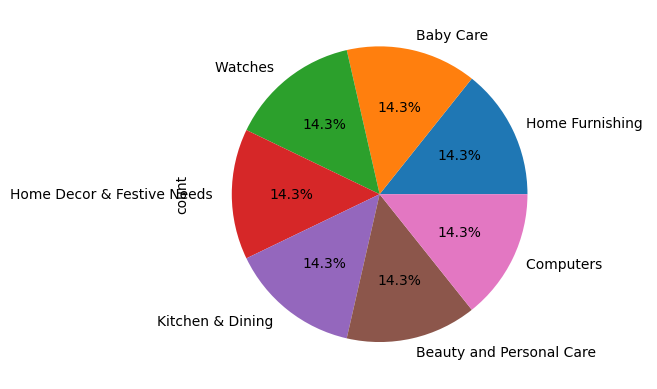

In [27]:
df_image.product_name.value_counts().plot(kind="pie", autopct='%1.1f%%')

La feature "product_name" comprend 7 catégories de produits qui sont toutes réparties équitablement dans le dataframe avec 150 produits par catégorie.

### <span style='background:black'>b/image</span>

In [28]:
le = preprocessing.LabelEncoder()
le.fit(df_image["product_name"])
df_image["label"] = le.transform(df_image["product_name"])
df_image.head(5)

,image,product_name,label
0,./data/source/Images/55b85ea15a1536d46b7190ad6...,Home Furnishing,4
1,./data/source/Images/7b72c92c2f6c40268628ec5f1...,Baby Care,0
2,./data/source/Images/64d5d4a258243731dc7bbb1ee...,Baby Care,0
3,./data/source/Images/d4684dcdc759dd9cdf4150469...,Home Furnishing,4
4,./data/source/Images/6325b6870c54cd47be6ebfbff...,Home Furnishing,4


In [30]:
%pycodestyle_off

# Obtenez les noms uniques des catégories
categories = df_image['product_name'].unique()

# Afficher les images de 3 produits de chaque catégorie
for nom in categories :
    print(nom)
    print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(nom)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

%pycodestyle_on

ValueError: Function <bound method VarWatcher.auto_run_pycodestyle of <pycodestyle_magic.VarWatcher object at 0x0000018F2D234990>> is not registered as a post_run_cell callback

## <span style='background:green'>3/ Prétraitement</span>

## <span style='background:green'>4/ Modèle Computer vision</span>

### <span style='background:black'>a/ SIFT</span>

### <span style='background:black'>b/ CNN Transfer learning</span>

Compétence OCR:

Prétraiter des données non structurées de type image en veillant au respect du droit à l’image et réaliser un feature engineering adapté aux modèles d'apprentissage afin d’obtenir un jeu de données exploitables.

CE1 Le candidat a utilisé des librairies spécialisées pour un premier traitement du contraste (ex. : openCV). 

CE2 Le candidat a présenté des opérations de retraitement d'images (par exemple passage en gris, filtrage du bruit, égalisation, floutage) sur un ou plusieurs exemples. 

CE3 Le candidat a élaboré une fonction permettant d'extraire des features ("feature engineering") de type "bag-of-images" via la génération de descripteurs (algorithmes ORB, ou SIFT, ou SURF). 

CE4 Le candidat a élaboré et exécuté une fonction permettant d'extraire des features ("feature engineering") via un algorithme de Transfer Learning basé sur des réseaux de neurones, comme par exemple CNN. 

CE5 Le candidat s’assure que les images utilisées ne relèvent pas d’une propriété intellectuelle.

Réduire la dimension de données de grande dimension, afin d'optimiser les temps d’entraînement des modèles.

CE1 Le candidat a justifié la nécessité de la réduction de dimension. 

CE2 Le candidat a appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 

CE3 Le candidat a justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP). 